In [1]:
import geopandas as gpd
import networkx as nx
from collections import defaultdict
import os
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import random
from shapely.geometry import LineString, Point, Polygon
from matplotlib.lines import Line2D
import plotly.graph_objects as go
from shapely.strtree import STRtree
from shapely.geometry import Point
import pickle
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
from folium.features import GeoJsonTooltip, GeoJsonPopup
from branca.colormap import linear

import matplotlib.pyplot as plt

In [2]:
# Load tram shapefile
shapefile_path = r"../dataset/BCN_GrafVial_Trams_ETRS89_SHP.shp"
trams_gdf = gpd.read_file(shapefile_path)

# Create graph and add tram nodes
G = nx.Graph()

for idx, row in trams_gdf.iterrows():
    tram_id = str(row['C_Tram'])
    G.add_node(tram_id, **row.drop('geometry'), geometry=row['geometry'], type='tram')

#Add edges between tram segments that share a node
node_to_trams = defaultdict(list)

for idx, row in trams_gdf.iterrows():
    tram_id = str(row['C_Tram'])
    for node in [row['C_Nus_I'], row['C_Nus_F']]:
        node_to_trams[node].append(tram_id)

for tram_list in node_to_trams.values():
    for i in range(len(tram_list)):
        for j in range(i + 1, len(tram_list)):
            tram_a = tram_list[i]
            tram_b = tram_list[j]
            if not G.has_edge(tram_a, tram_b):
                G.add_edge(tram_a, tram_b)

print(f" Graph built: {G.number_of_nodes()} tram nodes, {G.number_of_edges()} tram-tram edges.")

 Graph built: 14831 tram nodes, 35495 tram-tram edges.


In [3]:
# Load building GeoJSON
buildings_path = Path("../dataset/Barcelona.geojson")
buildings_gdf = gpd.read_file(buildings_path)

# Load CSV with FID to C_Tram
bldg_tram_csv = Path(r"../dataset/\Buildings_Roads_Network.csv")
bldg_tram_df = pd.read_csv(bldg_tram_csv)

bldg_tram_df['FID'] = bldg_tram_df['FID'].astype(int)
bldg_tram_df['C_Tram'] = bldg_tram_df['C_Tram'].astype(str)

bldg_to_trams = (
    bldg_tram_df.groupby('FID')['C_Tram']
    .apply(lambda s: sorted(set(s)))
    .to_dict()
)

# Add building nodes and connect to tram nodes
bldg_attr_lookup = buildings_gdf.set_index('FID').to_dict('index')
missing_trams = set()
num_edges = 0
num_bldg_nodes = 0

for fid, tram_ids in bldg_to_trams.items():
    bnode = f"B{int(fid):05d}"
    
    # Get building attributes
    attrs = bldg_attr_lookup.get(fid, {}).copy()
    attrs.update({'type': 'building', 'FID': fid})

    # Add building node
    G.add_node(bnode, **attrs)
    num_bldg_nodes += 1

    # Connect to tram segments
    for tram_id in tram_ids:
        tram_id = str(tram_id)
        if tram_id in G:
            G.add_edge(bnode, tram_id, relation='fronts')
            num_edges += 1
        else:
            missing_trams.add(tram_id)

print(f" Added {num_bldg_nodes} building nodes.")
print(f" Added {num_edges} edges connecting buildings to trams.")
if missing_trams:
    print(f" {len(missing_trams)} C_Tram IDs not found in graph (e.g. {list(missing_trams)[:5]})")


 Added 76347 building nodes.
 Added 107772 edges connecting buildings to trams.


In [ ]:
tmrt_stats_path = r"../dataset/patches/all_patch_summaries.csv"
bcn_csv_path = r"../dataset/BCN_GrafVial_With_Orientation.csv"
output_path = r"../dataset/BCN_GrafVial_With_Tmrt_graph.csv"

df_tmrt = pd.read_csv(tmrt_stats_path)
df_bcn = pd.read_csv(bcn_csv_path)

df_tmrt.columns = df_tmrt.columns.str.strip()
df_bcn.columns = df_bcn.columns.str.strip()

df_tmrt['C_Tram'] = df_tmrt['C_Tram'].astype(str).str.replace('tile_', '', regex=False).str.strip()
df_bcn['C_Tram'] = df_bcn['C_Tram'].astype(str).str.strip()

df_merged = df_bcn.merge(df_tmrt, on='C_Tram', how='left')

df_merged.to_csv(output_path, index=False, encoding='utf-8-sig')

print(f" Done. Merged Tmrt buffer stats into:\n{output_path}")


In [9]:
csv_path = r"../dataset/BCN_GrafVial_With_Tmrt_graph.csv"

df = pd.read_csv(csv_path)

df['C_Tram'] = df['C_Tram'].astype(str)

# Attach attributes to tram nodes
attached = 0
for idx, row in df.iterrows():
    tram_id = row['C_Tram']
    if tram_id in G.nodes:
        for col in df.columns:
            if col != 'C_Tram':
                G.nodes[tram_id][col] = row[col]
        attached += 1

print(f" Attributes from CSV attached to {attached} tram nodes.")

 Attributes from CSV attached to 14831 tram nodes.


In [10]:
sample_tram = df['C_Tram'].iloc[0]
print(f"Sample tram node {sample_tram} attributes:")
print(G.nodes[sample_tram])

Sample tram node T00001B attributes:
{'COORD_X': 432128.893, 'COORD_Y': 4581047.606, 'LONGITUD': 42.615, 'ANGLE': 15.04, 'C_Tram': 'T00001B', 'C_Nus_I': 'N00001D', 'C_Nus_F': 'N00002E', 'Distric_D': 1, 'NDistric_D': 'Ciutat Vella', 'Illa_D': 10390, 'CVia_D': 10900, 'TVia_D': 'Carrer', 'NVia_D': 'Carrer Pepe Rubianes', 'Tram_Dret': '2', 'Distric_E': 1, 'NDistric_E': 'Ciutat Vella', 'Illa_E': 10410, 'CVia_E': 10900, 'TVia_E': 'Carrer', 'NVia_E': 'Carrer Pepe Rubianes', 'Tram_Esq': '1', 'Width_D': 11, 'Width_E': 11, 'Width_Tot': 22, 'Width_B_D': 16, 'Width_B_E': 16, 'geometry': <LINESTRING (432108.315 4581042.075, 432149.471 4581053.136)>, 'type': 'tram', 'FID': 0, 'BuildingHeight_Right': 29.0, 'BuildingHeight_Left': 18.2, 'BuildingHeight_Mean': 23.6, 'Street_Buffer': 10.0, 'Number_of_Trees': 3, 'Mean_Tree_Height': 8.33, 'Mean_Tree_Circumfere': 0.67, 'Total_Canopy_Area_m2': 37.7, 'ANGLE_rad': 0.2624975194999471, 'ANGLE_sin': 0.2594933254150653, 'ANGLE_cos': 0.9657449011333328, 'buffer_are

In [11]:
print("Sample building → trams mapping:")
for i, (fid, trams) in enumerate(bldg_to_trams.items()):
    print(f"FID {fid} → Trams {trams}")
    if i >= 5:
        break

Sample building → trams mapping:
FID 1 → Trams ['T08450C']
FID 2 → Trams ['T12832T']
FID 3 → Trams ['T05534T']
FID 4 → Trams ['T15441U']
FID 5 → Trams ['T03372L', 'T20957C']
FID 6 → Trams ['T03365M', 'T20957C']


In [12]:
# Load left and right trees
left_file = r"../dataset/Street_Trees_Left.csv"
right_file = r"../dataset/Street_Trees_Right.csv"

df_left = pd.read_csv(left_file)
df_right = pd.read_csv(right_file)

# Clean column names
df_left.columns = df_left.columns.str.strip()
df_right.columns = df_right.columns.str.strip()

# Merge both sides
df_all_trees = pd.concat([df_left, df_right], ignore_index=True)

df_all_trees['C_Tram'] = df_all_trees['C_Tram'].astype(str)

# Add tree nodes and connect them to tram segments
tree_nodes_added = 0
tree_edges_added = 0
missing_trams = set()

for idx, row in df_all_trees.iterrows():
    tree_id = f"A_{row['source_pke']}"
    tram_id = row['C_Tram']

    tree_attrs = row.drop(['C_Tram'], errors='ignore').to_dict()
    tree_attrs.update({
        'type': 'tree',
        'source_pke': row['source_pke']
    })

    # Add tree node
    G.add_node(tree_id, **tree_attrs)
    tree_nodes_added += 1

    # Connect tree to tram segment
    if tram_id in G.nodes:
        G.add_edge(tree_id, tram_id, relation='tree_to_street')
        tree_edges_added += 1
    else:
        missing_trams.add(tram_id)

print(f"Added {tree_nodes_added} tree nodes.")
print(f"Added {tree_edges_added} edges connecting trees to tram segments.")
if missing_trams:
    print(f"{len(missing_trams)} tram IDs not found in graph (e.g. {list(missing_trams)[:5]})")


Added 219317 tree nodes.
Added 219317 edges connecting trees to tram segments.


In [13]:
# Load GeoJSON with tree data
tree_geojson_path = r"../dataset/bcn_trees.geojson"
trees_gdf = gpd.read_file(tree_geojson_path)

# Create exact matching tree IDs
trees_gdf['tree_id'] = trees_gdf['source:pkey'].apply(lambda x: f"A_{x}")

# Drop duplicates
trees_unique = trees_gdf.drop_duplicates(subset='tree_id', keep='first')

tree_attr_lookup = trees_unique.set_index('tree_id').to_dict('index')

# Attach to graph
added_attrs = 0
missing_nodes = 0

for tree_id, attrs in tree_attr_lookup.items():
    if tree_id in G.nodes:
        G.nodes[tree_id].update(attrs)
        added_attrs += 1
    else:
        missing_nodes += 1

print(f" Added attributes to {added_attrs} tree nodes in the graph.")
print(f" {missing_nodes} tree IDs from GeoJSON not found in the graph.")

 Added attributes to 176709 tree nodes in the graph.
 28051 tree IDs from GeoJSON not found in the graph.


In [14]:
sample_tree = next(n for n in G.nodes if str(n).startswith("A_"))
print(" Sample tree node:", sample_tree)
print(" Attributes:", G.nodes[sample_tree])

 Sample tree node: A_0000423AR
 Attributes: {'source_pke': '0000423AR', 'height': '15', 'circumfere': 1.5, 'type': 'tree', 'source:pkey': '0000423AR', 'lat': 41.4378722, 'lon': 2.1651098, 'species': 'Pinus pinea', 'species:es': 'Pino piñonero', 'species:ca': 'Pi pinyoner; pi pinyer', 'circumference': '1.5', 'planted_date': None, 'genus': 'Pinus', 'source': 'Opendata Ajuntament de Barcelona', 'geometry': <POINT (2.165 41.438)>}


In [15]:
trees_gdf = trees_gdf.to_crs(epsg=25831)

# Create 'tree_id'
trees_gdf['tree_id'] = trees_gdf['source:pkey'].apply(lambda x: f"A_{x}")

# Build spatial index
geoms = list(trees_gdf.geometry)
tree_ids = list(trees_gdf['tree_id'])
spatial_index = STRtree(geoms)

geom_to_id = dict(zip(geoms, tree_ids))

# Set max distance
max_distance = 10

# Track how many edges were added
proximity_edges = 0

# For each tree, find neighbors and connect
for i, geom in enumerate(geoms):
    current_id = tree_ids[i]
    if current_id not in G:
        continue

    nearby = spatial_index.query(geom.buffer(max_distance))

    for other in nearby:
        other_id = geom_to_id.get(other)
        if not other_id or other_id == current_id:
            continue

        if not G.has_edge(current_id, other_id):
            G.add_edge(current_id, other_id, relation='tree_proximity')
            proximity_edges += 1

print(f"Added {proximity_edges} edges between nearby trees (≤ {max_distance} meters).")

Added 0 edges between nearby trees (≤ 10 meters).


In [16]:
print(f"First 5 tree_ids in G: {[n for n in G.nodes if str(n).startswith('A_')][:5]}")
print(f"First 5 in GeoDataFrame: {trees_gdf['tree_id'].head()}")

First 5 tree_ids in G: ['A_0000423AR', 'A_0001156AR', 'A_0001954AR', 'A_0003541AR', 'A_0003545AR']
First 5 in GeoDataFrame: 0    A_0000022AR
1    A_0000025AR
2    A_0000028AR
3    A_0000386AR
4    A_0000387AR
Name: tree_id, dtype: object


In [17]:
print(trees_gdf.head(10))

  source:pkey        lat       lon height                          species  \
0   0000022AR  41.438442  2.165919   None                 Celtis australis   
1   0000025AR  41.437287  2.165353      5          Populus nigra 'Italica'   
2   0000028AR  41.437335  2.165436      5          Populus nigra 'Italica'   
3   0000386AR  41.437769  2.162530     10             Platanus x hispanica   
4   0000387AR  41.437788  2.162501     10             Platanus x hispanica   
5   0000388AR  41.437810  2.162471     15             Platanus x hispanica   
6   0000423AR  41.437872  2.165110     15                      Pinus pinea   
7   0001109AR  41.436425  2.164482     20          Populus nigra 'Italica'   
8   0001110AR  41.436449  2.164497      5  Fraxinus angustifolia 'Raywood'   
9   0001111AR  41.436470  2.164507     10          Populus nigra 'Italica'   

       species:es              species:ca circumference planted_date  \
0           Almez                Lledoner          None         None 

In [18]:
max_distance = 10

# Get all tree nodes from the graph
tree_node_ids = [n for n, d in G.nodes(data=True) if d.get("type") == "tree"]

# ilter trees_gdf to match those in the graph
trees_nearby = trees_gdf[trees_gdf['tree_id'].isin(tree_node_ids)].copy()

# Ensure projected CRS
if trees_nearby.crs.to_epsg() != 25831:
    trees_nearby = trees_nearby.to_crs(epsg=25831)

# Extract geometry and IDs
geoms = list(trees_nearby.geometry)
tree_ids = list(trees_nearby["tree_id"])

# Build spatial index
spatial_index = STRtree(geoms)
geom_to_id = dict(zip(geoms, tree_ids))

# Proximity-based edge creation
added = 0
seen_pairs = set()

for i, geom in enumerate(geoms):
    src_id = tree_ids[i]
    buffer = geom.buffer(max_distance)

    # Get geometries intersecting the buffer
    neighbor_indices = spatial_index.query(buffer)

    for j in neighbor_indices:
        neighbor_geom = geoms[j]
        tgt_id = tree_ids[j]

        if i == j:
            continue

        # Avoid duplicates
        pair = tuple(sorted((src_id, tgt_id)))
        if pair in seen_pairs:
            continue

        # Calculate actual distance
        dist = geom.distance(neighbor_geom)
        if dist <= max_distance:
            G.add_edge(src_id, tgt_id, relation="tree_proximity", distance=dist)
            seen_pairs.add(pair)
            added += 1

print(f"Added {added} proximity-based tree-to-tree edges (≤ {max_distance} meters)")

Added 274116 proximity-based tree-to-tree edges (≤ 10 meters)


VISUALIZE THE NODE


In [17]:
# Get tram nodes
tram_nodes = [n for n in G.nodes if isinstance(n, str) and n.startswith("T")]

#Pick 10 random C_Tram nodes
selected_trams = random.sample(tram_nodes, 10)
print("Selected tram segments:", selected_trams)

Selected tram segments: ['T09692W', 'T19113X', 'T11039Y', 'T17273E', 'T18124W', 'T07347A', 'T12900O', 'T11248F', 'T07874S', 'T15879U']


In [55]:
# Replace with one you know exists
#selected_trams = "T_08450C"

In [13]:
# Filter tram nodes by type or by name prefix
tram_nodes = [n for n, d in G.nodes(data=True) if str(n).startswith("T_") or d.get("type") == "tram"]
selected_trams = random.choice(tram_nodes)
print(f" Randomly selected C_Tram node: {selected_trams}")

neighbors = list(G.neighbors(selected_trams))

connected_trees = [n for n in neighbors if G.nodes[n].get("type") == "tree"]
connected_buildings = [n for n in neighbors if G.nodes[n].get("type") == "building"]

print(f" Connected trees: {len(connected_trees)}")
print(f" Connected buildings: {len(connected_buildings)}")

 Randomly selected C_Tram node: T13841Y
 Connected trees: 0
 Connected buildings: 10


In [22]:
def visualize_tram_subgraph(G, c_trams=None, sample=None, seed=42, save_path=None, show=True):
    tram_nodes = [n for n, d in G.nodes(data=True) if str(n).startswith("T") or d.get("type") == "tram"]

    if not tram_nodes:
        print(" No tram nodes found in the graph.")
        return

    if c_trams:
        if isinstance(c_trams, str):
            selected_trams = [c_trams]
        elif isinstance(c_trams, list):
            selected_trams = c_trams
        else:
            raise ValueError("'c_trams' must be a string or a list of tram node IDs.")
    elif sample:
        if sample > len(tram_nodes):
            raise ValueError(f"Requested sample size {sample} exceeds available tram nodes ({len(tram_nodes)}).")
        random.seed(seed)
        selected_trams = random.sample(tram_nodes, sample)
    else:
        raise ValueError("You must provide either 'c_trams' or 'sample'.")

    print(f"Visualizing {len(selected_trams)} tram segment(s): {selected_trams}")

    viridis = plt.colormaps['viridis']
    color_map_by_type = {
        'tram': viridis(0.1),
        'tree': viridis(0.9),
        'building': viridis(0.35)
    }

    for i, tram_id in enumerate(selected_trams, 1):
        if tram_id not in G:
            print(f" Tram ID '{tram_id}' not in graph — skipping.")
            continue

        neighbors = list(G.neighbors(tram_id))
        connected_trees = [n for n in neighbors if G.nodes[n].get("type") == "tree"]
        connected_buildings = [n for n in neighbors if G.nodes[n].get("type") == "building"]

        sub_nodes = [tram_id] + connected_trees + connected_buildings

        # Also include tree-tree proximity neighbors of connected trees
        for tree in connected_trees:
            tree_neighbors = list(G.neighbors(tree))
            for neighbor in tree_neighbors:
                if neighbor.startswith("A_") and neighbor not in sub_nodes:
                    sub_nodes.append(neighbor)

        H = G.subgraph(sub_nodes).copy()

        # Node colors
        node_colors = []
        for n in H.nodes:
            node_type = G.nodes[n].get("type", "tram")
            color = color_map_by_type.get(node_type, viridis(0.2))
            node_colors.append(color)

        # Position
        pos = nx.spring_layout(H, seed=seed, k=1.2)

        # Draw nodes
        plt.figure(figsize=(9, 7))
        nx.draw_networkx_nodes(H, pos, node_color=node_colors, node_size=600)
        nx.draw_networkx_labels(H, pos, font_size=7)

        # Separate edges by type
        standard_edges = []
        proximity_edges = []
        for u, v, d in H.edges(data=True):
            if d.get("relation") == "tree_proximity":
                proximity_edges.append((u, v))
            else:
                standard_edges.append((u, v))

        # Draw standard edges (solid)
        nx.draw_networkx_edges(H, pos, edgelist=standard_edges, edge_color="gray", width=1.5)

        # Draw proximity edges (dashed)
        nx.draw_networkx_edges(
            H, pos,
            edgelist=proximity_edges,
            edge_color="lightgray",
            style="dashed",
            width=1.0
        )

        # Legend
        #legend_handles = [
            #Line2D([0], [0], marker='o', color='w', label='Street', markerfacecolor=viridis(0.1), markersize=10),
            #Line2D([0], [0], marker='o', color='w', label='Tree', markerfacecolor=viridis(0.9), markersize=10),
            #Line2D([0], [0], marker='o', color='w', label='Building', markerfacecolor=viridis(0.35), markersize=10),
            #Line2D([0], [0], color='gray', lw=2, label='Connection'),
            #Line2D([0], [0], color='lightgray', lw=1.5, linestyle='--', label='Tree proximity')
        #]
        # Legend outside the plot (right side)
        #plt.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1, 0.5),frameon=False)
        plt.title(f"{tram_id}")
        plt.axis("off")
        #plt.tight_layout()

            
        if save_path:
            filename = f"{save_path}/tram_subgraph_{tram_id}.png"
            plt.savefig(filename, dpi=300, bbox_inches="tight")
            print(f"Saved: {filename}")

        plt.show()

In [87]:
#visualize_tram_subgraph(G, c_trams="T_08450C")

In [ ]:
#visualize_tram_subgraph(G, c_trams=["T_08450C", "T_12832T", "T_04201L"])

In [ ]:
visualize_tram_subgraph(G, c_trams=[
    'T03487V','T08615F', 'T18536M', 'T09424E', 'T00444Y', 'T07154T', 'T13023Y', 'T18203U', 'T02328D', 'T02906P', 'T14905B', 'T00662G', 'T03749Y', 'T19698H', 'T06320L', 'T11382K', 'T12125Z', 'T00538D', 'T08275F', 'T12219E', 'T19674Z', 'T20976F', 'T06856M', 'T20742P', 'T17162Y', 'T07508Z', 'T03911Q', 'T19595B', 'T08038U', 'T16605A', 'T04181K', 'T02998J', 'T08018Q', 'T03270G', 'T19580U', 'T14411K', 'T16062R', 'T12900O', 'T09909U', 'T05590B', 'T03854Y', 'T21124Z', 'T09441F', 'T03454M', 'T01781Q', 'T11244B', 'T05331K', 'T02871V', 'T02395O', 'T02191E', 'T11405A', 'T20458O', 'T12855A', 'T19702M', 'T18266J', 'T10602Z', 'T11100M', 'T08242W', 'T03405D', 'T15499M', 'T02575Q', 
'T02894C', 'T01927Q', 'T13865G', 'T08453F', 'T02719O', 'T04926B', 'T11254D', 'T20033T', 'T09418G', 'T13096P', 'T05348T', 'T03381M', 'T20968F', 'T07947S', 'T20509I', 'T18813O', 'T20347I', 'T08610A', 'T18062Z', 'T15512S', 'T03275L', 'T01955U', 'T07141O', 'T10130O', 'T10154W', 'T08485N', 'T16068X', 'T04249N', 'T02504B', 'T08690Q', 'T04844A', 'T00504T', 'T16230P', 'T18667W', 'T01777U', 'T05425P', 'T09168H', 'T19231C', 'T21315E'
])

In [ ]:
#visualize_tram_subgraph(G, sample=10, seed=42)
#visualize_tram_subgraph(G, sample=12, seed=42, save_path=r"your/path)

In [48]:
def visualize_tram_subgraph(G, c_trams=None, sample=None, seed=42, radius=1, save_path=None, show=True):
    tram_nodes = [n for n, d in G.nodes(data=True) if str(n).startswith("T") or d.get("type") == "tram"]

    if not tram_nodes:
        print("No tram nodes found in the graph.")
        return

    # Select tram(s)
    if c_trams:
        if isinstance(c_trams, str):
            selected_trams = [c_trams]
        elif isinstance(c_trams, list):
            selected_trams = c_trams
        else:
            raise ValueError("'c_trams' must be a string or list of tram node IDs.")
    elif sample:
        if sample > len(tram_nodes):
            raise ValueError(f"Sample size {sample} exceeds tram count ({len(tram_nodes)})")
        random.seed(seed)
        selected_trams = random.sample(tram_nodes, sample)
    else:
        raise ValueError("You must provide either 'c_trams' or 'sample'.")

    print(f"Visualizing {len(selected_trams)} tram segment(s): {selected_trams} (radius={radius})")

    viridis = plt.colormaps['viridis']
    color_map_by_type = {
        'tram': viridis(0.1),
        'tree': viridis(0.9),
        'building': viridis(0.35)
    }

    for tram_id in selected_trams:
        if tram_id not in G:
            print(f"Tram ID '{tram_id}' not in graph — skipping.")
            continue

        # Build ego graph (neighborhood around tram)
        H = nx.ego_graph(G, tram_id, radius=radius)

        # Assign node colors
        node_colors = []
        for n in H.nodes:
            node_type = G.nodes[n].get("type", "tram")
            color = color_map_by_type.get(node_type, viridis(0.2))
            node_colors.append(color)

        # Separate edges by type
        standard_edges = []
        proximity_edges = []
        for u, v, d in H.edges(data=True):
            if d.get("relation") == "tree_proximity":
                proximity_edges.append((u, v))
            else:
                standard_edges.append((u, v))

        plt.figure(figsize=(9, 7))
        pos = nx.spring_layout(H, seed=seed, k=1.2)
        nx.draw_networkx_nodes(H, pos, node_color=node_colors, node_size=600)
        nx.draw_networkx_labels(H, pos, font_size=7)

        nx.draw_networkx_edges(H, pos, edgelist=standard_edges, edge_color="gray", width=1.5)
        nx.draw_networkx_edges(H, pos, edgelist=proximity_edges, edge_color="lightgray", style="dashed", width=1.0)

        legend_handles = [
            Line2D([0], [0], marker='o', color='w', label='Street', markerfacecolor=viridis(0.1), markersize=10),
            Line2D([0], [0], marker='o', color='w', label='Tree', markerfacecolor=viridis(0.9), markersize=10),
            Line2D([0], [0], marker='o', color='w', label='Building', markerfacecolor=viridis(0.35), markersize=10),
            Line2D([0], [0], color='gray', lw=2, label='Connection'),
            Line2D([0], [0], color='lightgray', lw=1.5, linestyle='--', label='Tree proximity')
        ]
        plt.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1, 0.5),frameon=False)
        plt.title(f"{tram_id}_{radius} level connection")
        plt.axis("off")
        plt.tight_layout()

        if save_path:
            filename = f"{save_path}/tram_subgraph_{radius}_{tram_id}.png"
            plt.savefig(filename, dpi=300, bbox_inches="tight")
            print(f"Saved: {filename}")
        
        plt.show()

In [ ]:
#visualize_tram_subgraph(G, c_trams="T12345X", radius=1)
#visualize_tram_subgraph(G, sample=20, radius=1, seed=123)

# Show + Save images in a folder
visualize_tram_subgraph(G, sample=12, seed=42, radius=3)

In [ ]:
# Create a subgraph with only tree nodes and their proximity connections
tree_nodes = [n for n, d in G.nodes(data=True) if d.get("type") == "tree"]
tree_proximity_edges = [
    (u, v) for u, v, d in G.edges(data=True)
    if d.get("relation") == "tree_proximity" and u in tree_nodes and v in tree_nodes
]

# Build the tree-only subgraph
tree_subgraph = G.edge_subgraph(tree_proximity_edges).copy()

#Find connected components
components = list(nx.connected_components(tree_subgraph))

#Sort components by size
components_sorted = sorted(components, key=len, reverse=True)

print(f"Found {len(components_sorted)} clusters of connected trees.")
print(f"Largest cluster has {len(components_sorted[0])} trees.")

# Get the largest cluster as a subgraph
largest_tree_cluster = tree_subgraph.subgraph(components_sorted[0]).copy()

In [ ]:
# Extract nodes with lat/lon from largest_tree_cluster
cluster_nodes = []
for node, data in largest_tree_cluster.nodes(data=True):
    cluster_nodes.append({
        'id': node,
        'lat': data['lat'],
        'lon': data['lon'],
        'species': data.get('species'),
        'height': float(data['height']) if data.get('height') else None,
        'geometry': Point(data['lon'], data['lat'])
    })

gdf_cluster_nodes = gpd.GeoDataFrame(cluster_nodes, crs="EPSG:4326")

# Extract edges
cluster_edges = []
for u, v in largest_tree_cluster.edges():
    u_data = largest_tree_cluster.nodes[u]
    v_data = largest_tree_cluster.nodes[v]
    cluster_edges.append({
        'source': u,
        'target': v,
        'geometry': LineString([(u_data['lon'], u_data['lat']), (v_data['lon'], v_data['lat'])])
    })

gdf_cluster_edges = gpd.GeoDataFrame(cluster_edges, crs="EPSG:4326")

In [ ]:
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(largest_tree_cluster, seed=42)
nx.draw(largest_tree_cluster, pos, 
        node_color="green", edge_color="lightgray",
        with_labels=False, node_size=40)
plt.title("Largest Cluster of Proximal Trees")
plt.axis("off")
plt.show()

Save nodes, edges and Graph

In [ ]:
output_folder = r"../dataset"
os.makedirs(output_folder, exist_ok=True)

graph_path = os.path.join(output_folder, "city_graph.pkl")
with open(graph_path, "wb") as f:
    pickle.dump(G, f)
print(f"Graph saved to: {graph_path}")

# Save nodes as CSV
node_data = [{'node_id': n, **d} for n, d in G.nodes(data=True)]
df_nodes = pd.DataFrame(node_data)
nodes_csv_path = os.path.join(output_folder, "nodes.csv")
df_nodes.to_csv(nodes_csv_path, index=False)
print(f"Nodes saved to: {nodes_csv_path}")

# Save edges as CSV
edge_data = [{'source': u, 'target': v, **d} for u, v, d in G.edges(data=True)]
df_edges = pd.DataFrame(edge_data)
edges_csv_path = os.path.join(output_folder, "edges.csv")
df_edges.to_csv(edges_csv_path, index=False)
print(f"Edges saved to: {edges_csv_path}")


VISUALIZE CITY

In [8]:
file_path = r"../datase/city_graph.pkl"

with open(file_path, 'rb') as file:
    city_graph = pickle.load(file)

print(type(city_graph))

<class 'networkx.classes.graph.Graph'>


In [ ]:
# Create the base map centered around Barcelona
m = folium.Map(location=[41.3851, 2.1734], zoom_start=13, tiles="cartodbpositron")

# Add tram nodes with known coordinates
for node, data in G.nodes(data=True):
    if data.get("type") == "tram":
        geom = data.get("geometry")
        if geom and hasattr(geom, 'xy'):
            lon, lat = geom.xy[0][0], geom.xy[1][0]
            folium.CircleMarker(
                location=[lat, lon],
                radius=4,
                color="black",
                fill=True,
                fill_opacity=0.7,
                popup=f"Tram: {node}"
            ).add_to(m)

# Add tree nodes
for node, data in G.nodes(data=True):
    if data.get("type") == "tree":
        lat = data.get("lat")
        lon = data.get("lon")
        if lat and lon:
            folium.CircleMarker(
                location=[lat, lon],
                radius=3,
                color="green",
                fill=True,
                fill_opacity=0.6,
                popup=f"Tree: {node}"
            ).add_to(m)

output_map = r"../dataset/graph_map.html"
m.save(output_map)
print(f"Interactive map saved to: {output_map}")

In [ ]:
# Extract tram nodes and tram-tram edges
tram_nodes = [n for n, d in G.nodes(data=True) if d.get("type") == "tram"]
tram_edges = [(u, v) for u, v, d in G.edges(data=True) if u in tram_nodes and v in tram_nodes]

#Create subgraph
tram_subgraph = G.subgraph(tram_nodes).edge_subgraph(tram_edges).copy()

# Compute node degrees
degrees = dict(tram_subgraph.degree())
degree_values = list(degrees.values())

# Normalize degrees for colormap
norm = colors.Normalize(vmin=min(degree_values), vmax=max(degree_values))
cmap = cm.get_cmap('viridis')
node_colors = [cmap(norm(degrees[n])) for n in tram_subgraph.nodes]

fig, ax = plt.subplots(figsize=(12, 12))
pos = nx.spring_layout(tram_subgraph, seed=42, k=0.15)

nx.draw_networkx_nodes(tram_subgraph, pos,
                       node_size=10,
                       node_color=node_colors,
                       alpha=0.8,
                       ax=ax)
nx.draw_networkx_edges(tram_subgraph, pos, alpha=0.2, ax=ax)

# Colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, shrink=0.7)
cbar.set_label("Node Degree (Connections)", fontsize=12)

ax.set_title("Street Segment Graph (Colored by Node Degree)")
ax.axis('off')
plt.tight_layout()
plt.show()

In [7]:
# Load the graph
path = r"../datase/largest_tree_cluster.pkl"
with open(path, "rb") as f:
    G_tree = pickle.load(f)

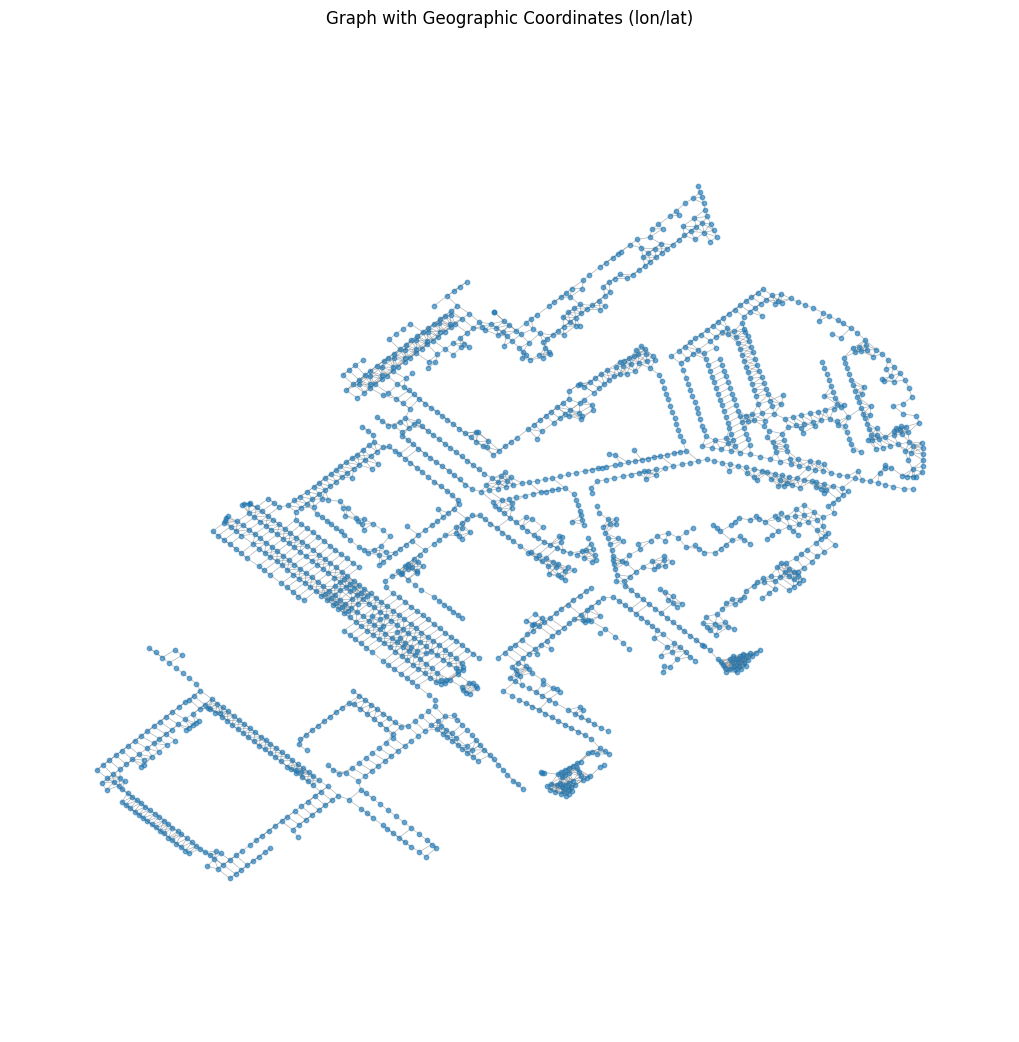

In [19]:
# Create position dict: node -> (lon, lat)
pos = {node: (data['lon'], data['lat']) for node, data in G_tree.nodes(data=True)}

# Plot
plt.figure(figsize=(10, 10))
nx.draw(G_tree, pos=pos, node_size=10, edge_color='gray', alpha=0.6, width=0.5)
plt.title("Graph with Geographic Coordinates (lon/lat)")
plt.axis("equal")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [24]:
# Convert nodes to GeoDataFrame
node_data = []
for node, data in G_tree.nodes(data=True):
    point = Point(data['lon'], data['lat'])
    node_data.append({
        'id': node,
        'lat': data['lat'],
        'lon': data['lon'],
        'species': data.get('species', ''),
        'height': float(data['height']) if data['height'] not in [None, ''] else None,
        'geometry': point
    })

# GeoDataFrame with only clean fields
gdf_nodes = gpd.GeoDataFrame(node_data, crs="EPSG:4326")


# Convert edges to GeoDataFrame
edge_data = []
for u, v in G_tree.edges():
    u_data = G_tree.nodes[u]
    v_data = G_tree.nodes[v]
    line = LineString([(u_data['lon'], u_data['lat']), (v_data['lon'], v_data['lat'])])
    edge_data.append({'source': u, 'target': v, 'geometry': line})

gdf_edges = gpd.GeoDataFrame(edge_data, crs="EPSG:4326")

In [31]:
# Create map
center = [gdf_nodes.geometry.y.mean(), gdf_nodes.geometry.x.mean()]
m = folium.Map(location=center, zoom_start=15, tiles="cartodbpositron")

# Add edges as GeoJson (still works fine)
folium.GeoJson(
    gdf_edges,
    name="Tree Connections",
    style_function=lambda feature: {
        'color': 'gray',
        'weight': 1,
        'opacity': 0.5,
    }
).add_to(m)

# Add color scale (based on height)
colormap = linear.YlGnBu_09.scale(
    gdf_nodes["height"].min(),
    gdf_nodes["height"].max()
)

colormap = colormap.to_step(10)
colormap.caption = "Tree Height (m)"
colormap.add_to(m)


# Add nodes as individual CircleMarkers
for _, row in gdf_nodes.iterrows():
    color = colormap(row["height"]) if row["height"] is not None else 'gray'
    folium.CircleMarker(
        location=(row["lat"], row["lon"]),
        radius=4,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.8,
        popup=folium.Popup(f"<b>Species:</b> {row['species']}<br><b>Height:</b> {row['height']} m"),
        tooltip=f"ID: {row['id']}"
    ).add_to(m)

folium.LayerControl().add_to(m)

m